In [30]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import WOEEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [32]:

# Setting Seaborn styles
sns.set_style('whitegrid')
sns.set_palette('pastel')

# Suppress warnings
import warnings
warnings.simplefilter("ignore")

# Load Data
train_df = pd.read_csv("C:\\Users\\arehm\\Downloads\\frauddetection\\fraudTrain.csv", index_col='Unnamed: 0')
test_df = pd.read_csv("C:\\Users\\arehm\\Downloads\\frauddetection\\fraudTest.csv", index_col='Unnamed: 0')


In [33]:

# Exploratory Data Analysis
print("Sample Data:\n", train_df.head(3))
print("\nDataset Info:")
train_df.info()



Sample Data:
   trans_date_trans_time            cc_num                         merchant  \
0   2019-01-01 00:00:18  2703186189652095       fraud_Rippin, Kub and Mann   
1   2019-01-01 00:00:44      630423337322  fraud_Heller, Gutmann and Zieme   
2   2019-01-01 00:00:51    38859492057661             fraud_Lind-Buckridge   

        category     amt      first     last gender  \
0       misc_net    4.97   Jennifer    Banks      F   
1    grocery_pos  107.23  Stephanie     Gill      F   
2  entertainment  220.11     Edward  Sanchez      M   

                         street            city  ...      lat      long  \
0                561 Perry Cove  Moravian Falls  ...  36.0788  -81.1781   
1  43039 Riley Greens Suite 393          Orient  ...  48.8878 -118.2105   
2      594 White Dale Suite 530      Malad City  ...  42.1808 -112.2620   

   city_pop                                job         dob  \
0      3495          Psychologist, counselling  1988-03-09   
1       149  Special educat

In [34]:
print("\nShape of Dataset:", train_df.shape)
is_fraud_counts = train_df["is_fraud"].value_counts()
print("\nFraudulent and Non-Fraudulent Transactions:")
print("Fraudulent:", is_fraud_counts[1])
print("Non-Fraudulent:", is_fraud_counts[0])



Shape of Dataset: (1296675, 22)

Fraudulent and Non-Fraudulent Transactions:
Fraudulent: 7506
Non-Fraudulent: 1289169


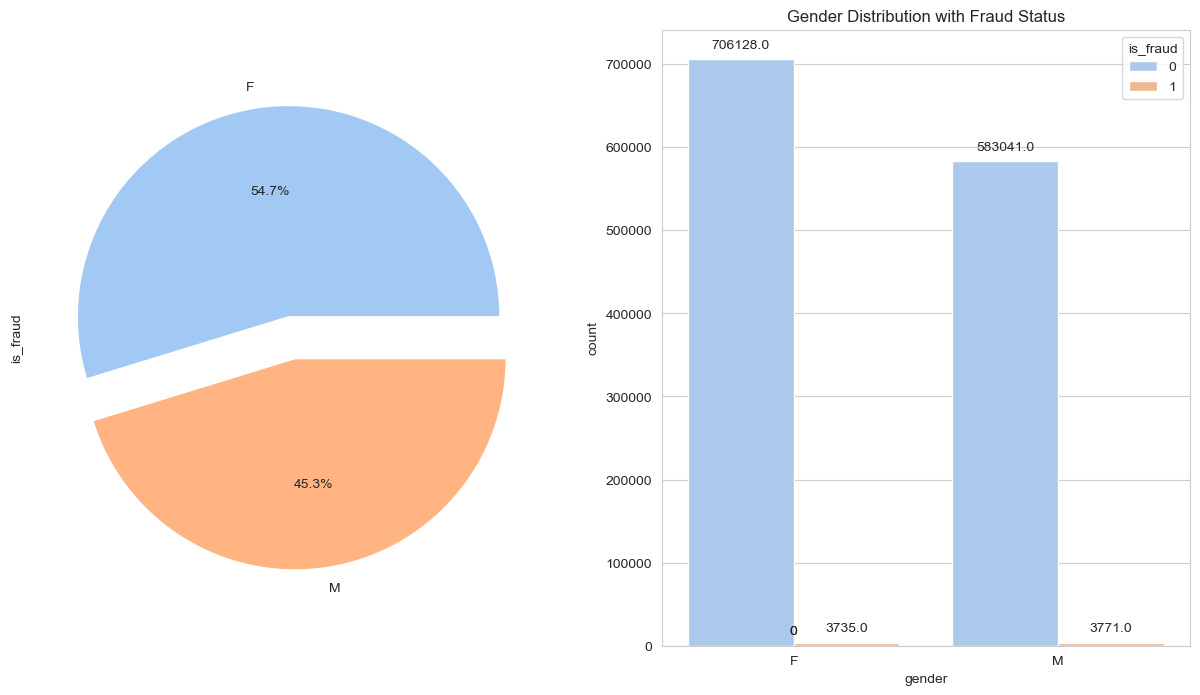

In [35]:

# Gender Distribution Visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# Pie Chart for Gender Distribution
explode = [0.1, 0.1]
train_df.groupby('gender')['is_fraud'].count().plot.pie(explode=explode, autopct="%1.1f%%", ax=ax[0])

# Bar Chart for Gender Distribution with Fraud Status
gender_plot = sns.countplot(x="gender", hue="is_fraud", data=train_df, ax=ax[1])
for p in gender_plot.patches:
    gender_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title("Gender Distribution with Fraud Status")
plt.show()


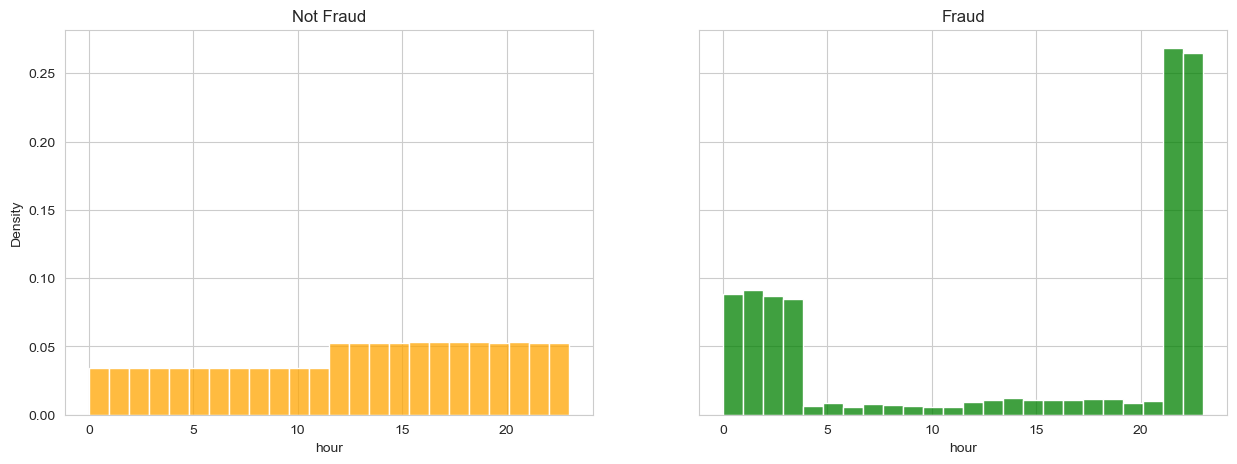

In [36]:

# Feature Engineering
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'], format='mixed')
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'], format='mixed')
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour
test_df['hour'] = test_df['trans_date_trans_time'].dt.hour
train_df['month'] = train_df['trans_date_trans_time'].dt.month
test_df['month'] = test_df['trans_date_trans_time'].dt.month

# Plot Fraud Transactions by Hour
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 0], stat="density", bins=24, ax=ax1, color="orange")
sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 1], stat="density", bins=24, ax=ax2, color="green")
ax1.set_title("Not Fraud")
ax2.set_title("Fraud")
plt.show()



In [37]:

# Data Pre-processing
columns_to_drop = ['first', 'unix_time', 'dob', 'cc_num', 'zip', 'city', 'street', 'state', 'trans_num', 'trans_date_trans_time']
train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)

# Clean Merchant Column
train_df['merchant'] = train_df['merchant'].str.replace('fraud_', '')


In [38]:

# Encoding Features
train_df['gender'] = train_df['gender'].map({'F': 0, 'M': 1})
for col in ['job', 'merchant', 'category', 'lat', 'last']:
    train_df[col] = WOEEncoder().fit_transform(train_df[col], train_df['is_fraud'])


In [39]:

# Handling Imbalanced Data using Downsampling
No_class = train_df[train_df["is_fraud"] == 0]
Yes_class = train_df[train_df["is_fraud"] == 1]
No_class_downsampled = resample(No_class, replace=False, n_samples=len(Yes_class), random_state=42)
balanced_data = pd.concat([Yes_class, No_class_downsampled])


In [40]:

# Split Data
X = balanced_data.drop("is_fraud", axis=1)
y = balanced_data["is_fraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=65)


In [44]:

# Scale Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [48]:

# Model Training - Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print("\nLogistic Regression Model Performance:")
print(classification_report(y_test, lr_predictions))
print(f"Accuracy: {lr_accuracy:.2f}")


Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1486
           1       0.91      0.77      0.83      1517

    accuracy                           0.85      3003
   macro avg       0.86      0.85      0.85      3003
weighted avg       0.86      0.85      0.84      3003

Accuracy: 0.85
